In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from sklearn.datasets import load_boston
from torch import nn
from tqdm.notebook import tqdm

%matplotlib inline

### Задание 1

#### Разминка.

При помощи numpy посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [3]:
squares = np.sum(el**2 for el in range(1,10001))
print(squares)

333383335000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


### Задание 2

#### Разминка на pytorch

При помощи pytorch посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [4]:
els = [el**2 for el in range(1,10001)]
els = torch.Tensor(els)
sq_torch = torch.sum(els)
print(sq_torch)

tensor(3.3338e+11)


### Задание

1. Реализовать сетку в виде класса
2. Реализовать процедуру загрузки данных FashionMNIST 
3. Обучить сетку

In [18]:
class Model(nn.Module):
 def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

 def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)


#### Как написать цикл обучения и отслеживать метрики
 
Давайте теперь соберем теперь загрузку данных, создание модели и обучим на уже созданном для нас датасете MNIST

In [10]:
# используем готовый класс от торча для загрузки данных для тренировки
f_mnist_train = torchvision.datasets.FashionMNIST(
    "./mnist/", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor()
) 
f_mnist_val = torchvision.datasets.FashionMNIST(
    "./mnist/",
    train=False, 
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    f_mnist_train, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
) 

val_dataloader = torch.utils.data.DataLoader(
    f_mnist_val, 
    batch_size=4, 
    shuffle=True, 
    num_workers=1
)

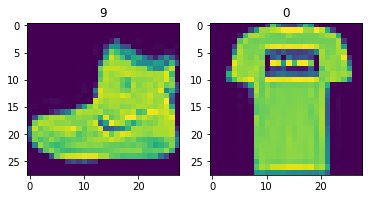

In [11]:
# посмотрим на то, с чем мы работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(f_mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(f_mnist_train[i][1]))
plt.show()

In [14]:
model = Model()

In [15]:
[x for x in model.named_parameters()] 

[('linear_relu_stack.0.weight', Parameter containing:
  tensor([[-0.0066, -0.0002,  0.0029,  ..., -0.0244,  0.0258, -0.0253],
          [-0.0314, -0.0082, -0.0041,  ..., -0.0254,  0.0326, -0.0320],
          [ 0.0114, -0.0331, -0.0088,  ..., -0.0013, -0.0164, -0.0263],
          ...,
          [ 0.0001,  0.0152, -0.0121,  ..., -0.0309, -0.0056,  0.0186],
          [-0.0274, -0.0058, -0.0229,  ..., -0.0297,  0.0285, -0.0278],
          [ 0.0346, -0.0082, -0.0044,  ...,  0.0282, -0.0202, -0.0124]],
         requires_grad=True)),
 ('linear_relu_stack.0.bias', Parameter containing:
  tensor([ 0.0235,  0.0048,  0.0098, -0.0056,  0.0226,  0.0070,  0.0305, -0.0225,
          -0.0206,  0.0064, -0.0278,  0.0115,  0.0260,  0.0177,  0.0237, -0.0070,
           0.0265, -0.0357,  0.0005,  0.0336, -0.0170,  0.0058, -0.0308, -0.0240,
          -0.0055, -0.0023, -0.0278, -0.0173,  0.0076,  0.0172,  0.0157, -0.0302,
          -0.0227, -0.0269,  0.0228,  0.0317, -0.0162, -0.0317,  0.0160,  0.0128,
     

_Красиво_ трекать метрики в полуавтоматическом режиме мы будем в [wandb](https://wandb.ai). Для этого регистрируемся на сайте, устанавливаем и логинимся(это того стоит):

In [17]:
!pip install wandb --upgrade --quiet
import wandb

# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
wandb.login()
# инициализируем проект
wandb.init(project="pytorch-demo")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bazhanka (use `wandb login --relogin` to force relogin)


Можно перейти по ссылке и следить за нашей моделью прямо во время обучения!

In [19]:
# всего у нас будет 5 эпох (5 раз подряд пройдемся по всем батчам из трейна)
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):    # берем батч из трейн лоадера
        y_pred = model(x_train)                        # делаем предсказания
        
        loss = F.cross_entropy(y_pred, y_train)        # считаем лосс
        loss.backward()                                # считаем градиенты обратным проходом
        
        optimizer.step()                               # обновляем параметры сети
        optimizer.zero_grad()                          # обнуляем посчитанные градиенты параметров
    
    if epoch % 2 == 0:
        val_loss = []                                  # сюда будем складывать **средний по бачу** лосс
        val_accuracy = []
        with torch.no_grad():                          # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader):  # берем батч из вал лоадера
                y_pred = model(x_val)                  # делаем предсказания
                loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.numpy())          # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
          
        # скидываем метрики на wandb и автоматом смотрим на графики
        wandb.log({"mean val loss": np.mean(val_loss),
                   "mean val accuracy": np.mean(val_accuracy)})
        
        # печатаем метрики
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.4684775471687317, accuracy: 0.8312


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.40380918979644775, accuracy: 0.8511


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.43415889143943787, accuracy: 0.8444


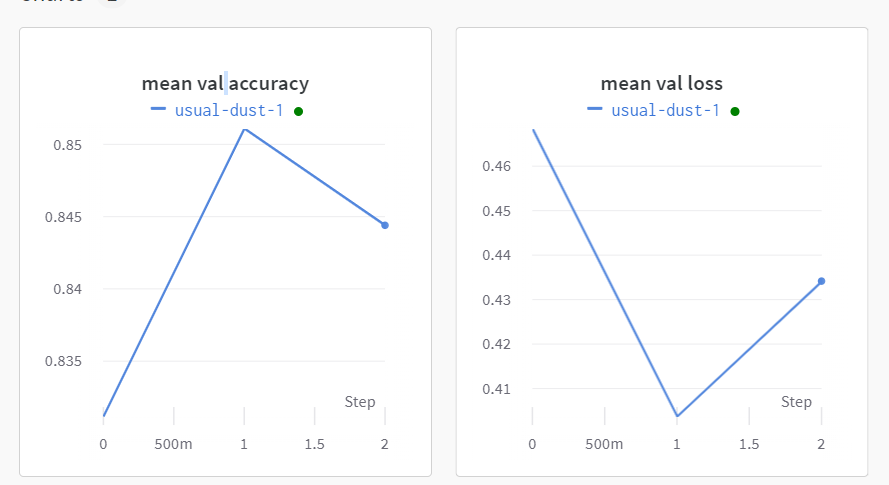